Total Distance: 100.0 

Route for vehicle 1: [0, 4, 1, 0]
Total Distance for vehicle 1: 50
Route for vehicle 2: [0, 3, 2, 0]
Total Distance for vehicle 2: 50


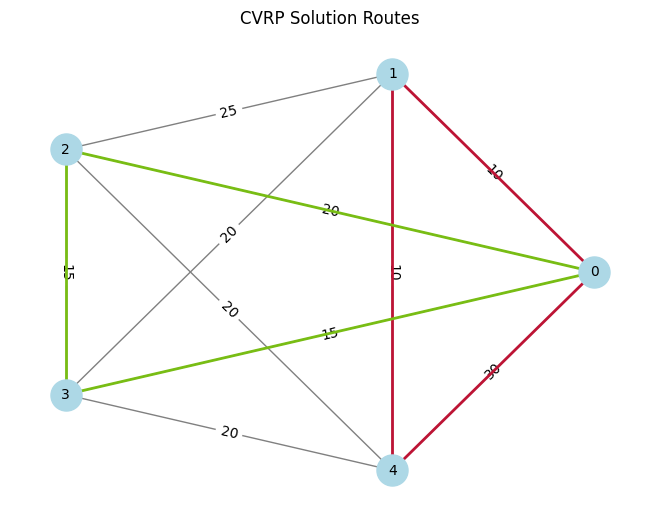

In [9]:
# !pip install pyomo
# !apt-get install -y -qq glpk-utils
from pyomo.environ import *
import matplotlib.pyplot as plt
import networkx as nx
import random

def solve_CVRP_with_pyomo(distance_matrix, demand, vehicle_capacity, num_vehicles, depot=0, show_plot=True):
    num_locations = len(distance_matrix)
    locations = range(num_locations)

    # Initialize the Pyomo model
    model = ConcreteModel()

    # Sets
    model.Locations = Set(initialize=locations)
    model.Vehicles = Set(initialize=range(num_vehicles))
    model.Pairs = Set(initialize=[(i, j) for i in locations for j in locations if i != j])

    # Parameters
    model.distance = Param(model.Pairs, initialize={(i, j): distance_matrix[i][j] for i, j in model.Pairs})
    model.demand = Param(model.Locations, initialize={i: demand[i] for i in locations})
    model.capacity = vehicle_capacity

    # Decision variables: x[i,j,k] = 1 if vehicle k travels from location i to location j, else 0
    model.x = Var(model.Pairs, model.Vehicles, within=Binary)
    model.u = Var(model.Locations, within=NonNegativeReals, bounds=(0, vehicle_capacity))

    # Objective function: minimize total travel distance
    def objective_function(model):
        return sum(model.distance[i, j] * model.x[i, j, k] for i, j in model.Pairs for k in model.Vehicles)
    model.objective = Objective(rule=objective_function, sense=minimize)

    # Constraints

    # Each customer is visited exactly once by one vehicle
    def visit_constraint(model, j):
        if j == depot:
            return Constraint.Skip
        return sum(model.x[i, j, k] for i, j_ in model.Pairs if j_ == j for k in model.Vehicles) == 1
    model.visit_constraint = Constraint(model.Locations, rule=visit_constraint)

    # Flow conservation for each vehicle: if a vehicle arrives at a location, it must leave that location
    def flow_constraint(model, k, i):
        if i == depot:
            return Constraint.Skip
        return sum(model.x[i, j, k] for j in locations if (i, j) in model.Pairs) == sum(model.x[j, i, k] for j in locations if (j, i) in model.Pairs)
    model.flow_constraint = Constraint(model.Vehicles, model.Locations, rule=flow_constraint)

    # Vehicle capacity constraint
    def capacity_constraint(model, k):
        return sum(model.demand[j] * model.x[i, j, k] for i, j in model.Pairs if j != depot) <= model.capacity
    model.capacity_constraint = Constraint(model.Vehicles, rule=capacity_constraint)

    # Start and end at depot constraint for each vehicle
    def depot_start_constraint(model, k):
        return sum(model.x[depot, j, k] for j in locations if j != depot) == 1
    model.depot_start_constraint = Constraint(model.Vehicles, rule=depot_start_constraint)

    def depot_end_constraint(model, k):
        return sum(model.x[i, depot, k] for i in locations if i != depot) == 1
    model.depot_end_constraint = Constraint(model.Vehicles, rule=depot_end_constraint)

    # Subtour elimination constraint
    def subtour_constraint(model, i, j, k):
        if i != depot and j != depot and i != j:
            return model.u[i] - model.u[j] + vehicle_capacity * model.x[i, j, k] <= vehicle_capacity - model.demand[j]
        return Constraint.Skip
    model.subtour_constraint = Constraint(model.Pairs, model.Vehicles, rule=subtour_constraint)

    # Solve the model
    SolverFactory('glpk').solve(model) # Ensure you have GLPK installed, or use a different solver like 'cbc' or 'gurobi'

    # Retrieve and print the solution
    routes = {k: [] for k in range(num_vehicles)}
    distances = {k: 0 for k in range(num_vehicles)}

    # Print the overall total distance using the objective value
    total_distance = value(model.objective)
    print(f"Total Distance: {total_distance}", "\n")

    for k in model.Vehicles:
        route = [depot]
        current_location = depot
        total_distance_vehicle = 0
        while True:
            next_location = next((j for i, j in model.Pairs if model.x[i, j, k].value == 1 and i == current_location), None)
            if next_location is None or next_location == depot:
                break
            route.append(next_location)
            total_distance_vehicle += distance_matrix[current_location][next_location]
            current_location = next_location
        route.append(depot)
        total_distance_vehicle += distance_matrix[current_location][depot]
        routes[k] = route
        distances[k] = total_distance_vehicle
        print(f"Route for vehicle {k + 1}: {route}")
        print(f"Total Distance for vehicle {k + 1}: {total_distance_vehicle}")

    # Plot the routes if requested
    if show_plot:
        plot_cvrp_solution(distance_matrix, routes)

def plot_cvrp_solution(distance_matrix, routes):
    G = nx.Graph()
    num_locations = len(distance_matrix)

    for i in range(num_locations):
        for j in range(i + 1, num_locations):
            if distance_matrix[i][j] > 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{distance_matrix[i][j]}" for i, j in G.edges()})

    colors = ["#bd1435", "#78bd14", "#1497bd", "purple", "orange", "pink"]
    for k, route in routes.items():
        route_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=2, edge_color=colors[k % len(colors)])

    plt.title("CVRP Solution Routes")
    plt.show()

# Example usage
if __name__ == "__main__":
  distance_matrix = [
    [0, 10, 20, 15, 30],
    [10, 0, 25, 20, 10],
    [20, 25, 0, 15, 20],
    [15, 20, 15, 0, 20],
    [30, 10, 20, 20, 0]
    ]
  demand = [0, 10, 20, 30, 40]  # 0 demand for the depot
  vehicle_capacity = 50
  num_vehicles = 2

  solve_CVRP_with_pyomo(distance_matrix, demand, vehicle_capacity, num_vehicles, show_plot=True)